### Install all the necessary packages

In [1]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


### Import all the necessary libraries

In [2]:
# Importing required libraries (os, sys, numpy, pandas, matplotlib)
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PySpark Libraries
import pyspark as sprk
import pyspark.ml as spark_ml
import pyspark.mllib as spark_mllib
import pyspark.sql as spark_sql

# Scikit-Learn Libraries
import sklearn as sk
import sklearn.metrics as sk_metrics
import sklearn.model_selection as sk_model_selection
import sklearn.utils as sk_utils

# TensorFlow Libraries
import tensorflow as tf

# Other Libraries
import urllib.parse as urlparse
import scipy.sparse as sp_sparse

# Setting the environment variables for PySpark, without it PySpark will not work
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

C:\Users\siman\AppData\Local\Temp\ipykernel_23944\2910101524.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Creating the pyspark environment, setting the configurations and preparing the spark session

In [3]:
sc = sprk.SparkContext()
sqlContext = spark_sql.SQLContext(sc)

spark = spark_sql.SparkSession.builder.appName("Detecting-Malicious-URL App").getOrCreate()

c:\Users\siman\.conda\envs\tf\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Prepare the dataset and preprocess the data

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('url_dataset_updated.csv')

# Drop all duplicates from df
df = df.drop_duplicates()

# Reset the index after dropping duplicates
df = df.reset_index(drop=True)

# Rename the column 'URL' to 'url'
df = df.rename(columns={'Label': 'label'})

url_column_name = 'URL'  # Replace with your actual column name

# Function to concatenate "https://" to URLs labeled with 0
def add_https(url, label):
    if label == 0:
        return "https://" + url
    else:
        return url

# Apply the function to the URL column
df[url_column_name] = df.apply(lambda row: add_https(row[url_column_name], row['label']), axis=1)

# Separate the dataset into malicious and benign
malicious_df = df[df['label'] == 1]
benign_df = df[df['label'] == 0]

# Randomly sample 150,000 entries from each
malicious_sampled_df = sk_utils.resample(malicious_df, n_samples=150000, random_state=42)
benign_sampled_df = sk_utils.resample(benign_df, n_samples=150000, random_state=42)

# Combine the sampled data
balanced_df = pd.concat([malicious_sampled_df, benign_sampled_df])

# Shuffle the combined dataset to mix malicious and benign URLs
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a Spark DataFrame from the balanced dataset
spark_dff = sqlContext.createDataFrame(balanced_df)

#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = spark_ml.feature.RegexTokenizer(inputCol="URL", outputCol="Words", pattern="\\W")

# CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = spark_ml.feature.CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

# IDF is an Estimator which is fit on a dataset and produces an IDFModel
idf = spark_ml.feature.IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

# Create the pipline 
pipeline = spark_ml.Pipeline(stages=[regexTokenizer, countVectors, idf ])

# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(spark_dff)

#Transform the pipeline to dataset
# Pass 'spark_dff' in the param to set Balanced datasets
dataset = pipelineFit.transform(spark_dff)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 239971
Test Dataset Count: 60029
Total Dataset Count: 300000
+--------------------+-----+--------------------+--------------------+--------------------+
|                 URL|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://etransfers...|    1|[http, etransfers...|(10000,[2,3,4,79,...|(10000,[2,3,4,79,...|
|http://betterheal...|    1|[http, betterheal...|(10000,[1,2,3,10,...|(10000,[1,2,3,10,...|
|http://lloydsbank...|    1|[http, lloydsbank...|(10000,[1,2,3,7,2...|(10000,[1,2,3,7,2...|
|  https://archive.md|    0|[https, archive, md]|(10000,[0,803,207...|(10000,[0,803,207...|
|https://pkg00-atx...|    0|[https, pkg00, at...|(10000,[0,1],[1.0...|(10000,[0,1],[0.2...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Logisitic Regression Model


True Positives: 26812
True Negative: 29868
False Positive: 196
False Negative: 3153
Total: 60029

Accuracy: 94.421
F-Score: 94.1217771
Recall: 89.4777
Precision: 99.2743


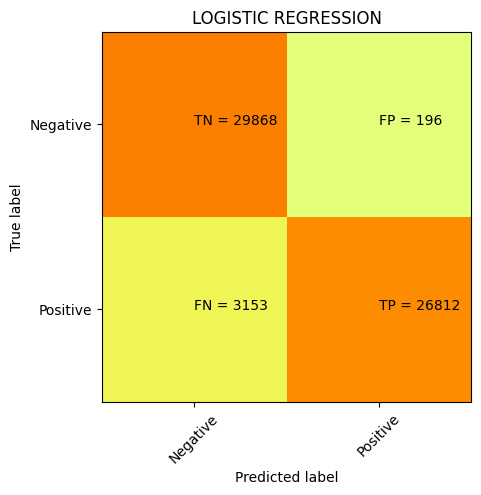

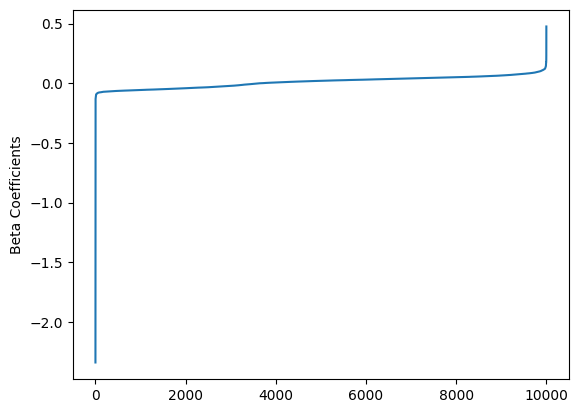

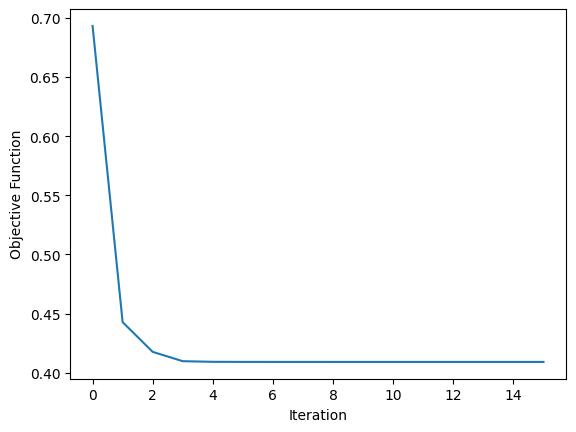

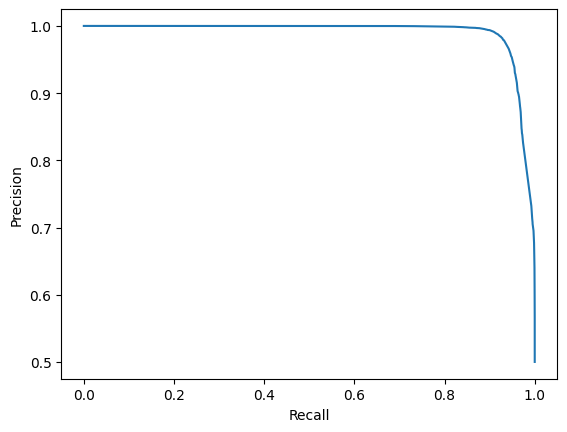

areaUnderROC: 0.9876010865283023


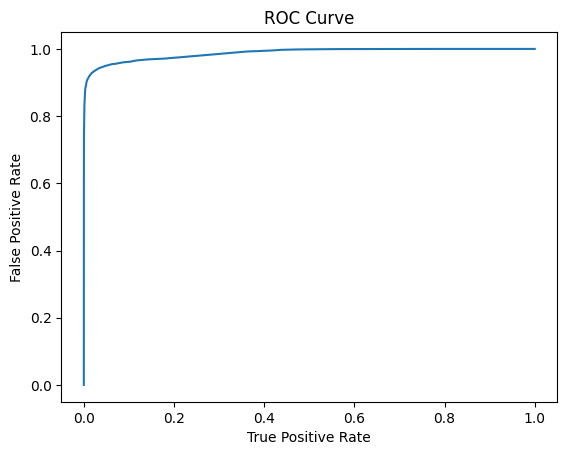

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9974495450...|0.0018810134...|
|0.9951312930...|0.0037584919...|
|0.9935000728...|0.0055993088...|
|0.9924545163...|0.0074532718...|
|0.9912315544...|0.0093368049...|
|0.9899971406...|0.0112826800...|
|0.9889433010...|0.0134549185...|
|0.9879757716...|0.0153107199...|
|0.9870654936...|0.0171794342...|
|0.9860185433...|0.0190119402...|
+---------------+---------------+
only showing top 10 rows



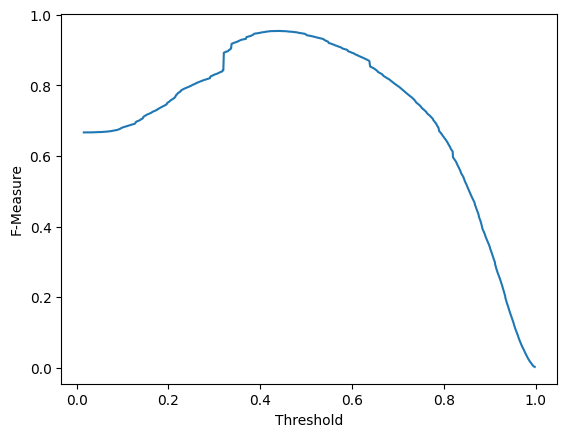

+--------------------------------------------------------------------------------+-----+----------+
|                                                                             URL|label|prediction|
+--------------------------------------------------------------------------------+-----+----------+
|https://rancher-ui.us-east-1-latest-rancher.6f51124c4bdbcadd.hsp.philips.com....|    0|       0.0|
|https://cdn.inst-fs-iad-prod.inscloudgate.net.1.o1f49mh68j4i.1.prx.useast.v1a...|    0|       0.0|
|https://prod.notifications.prod.mheducation.com.1.o1f49mh68j4i.1.prx.useast.v...|    0|       0.0|
|https://api.mex01.mex.pre.mx1.paas.cloudcenter.corp.sigenv1.qq.p1.ash.opendns...|    0|       0.0|
|      https://hub-prod-us-gateway-ecs-alb-1433825817.us-east-1.elb.amazonaws.com|    0|       0.0|
|   https://apps.apis.classlink.com.1.o1f49mh68j4i.1.prx.useast.v1api.securly.com|    0|       0.0|
|                  https://rnps-feature-discovery-archive.rnps.dl.playstation.net|    0|       0.0|


In [5]:
#==============[ LOGISTIC REGRESSION ]=========================
r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0


# Build logistic regresssion model
for i in range(1,6):
    
    dataset = pipelineFit.transform(spark_dff)

    #randomly split the dataset to traning and testing 80%, 20% respectively
    #(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
    #print("\n")
    #trainingData.groupby('label').count().toPandas()
    
    lr = spark_ml.classification.LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    rfModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = rfModel.transform(testData)

df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


#===========================ploting

#plt.clf()
lr_predictions = rfModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = sk_metrics.confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

beta = np.sort(rfModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = rfModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("URL", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)
    
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

#### Random Forest Model


True Positives: 22855
True Negative: 29742
False Positive: 322
False Negative: 7110
Total: 60029

Accuracy: 87.6193
F-Score: 86.0148281
Recall: 76.2723
Precision: 98.6107


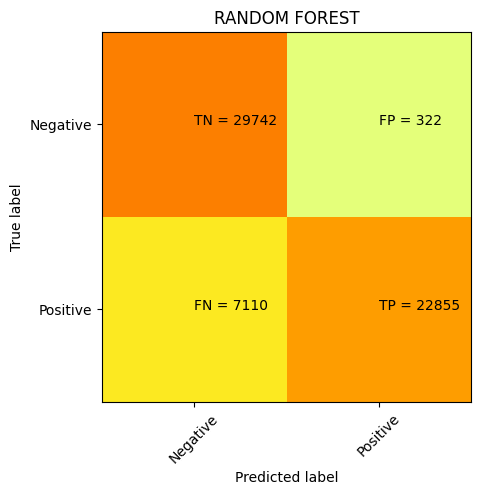

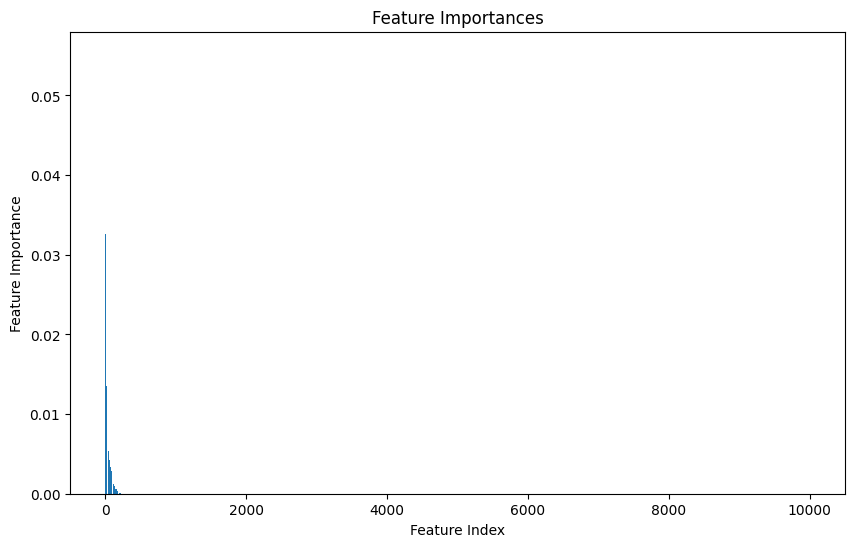

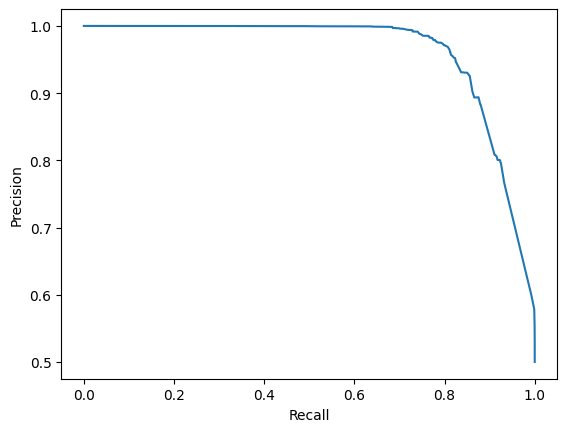

areaUnderROC: 0.949721355499512


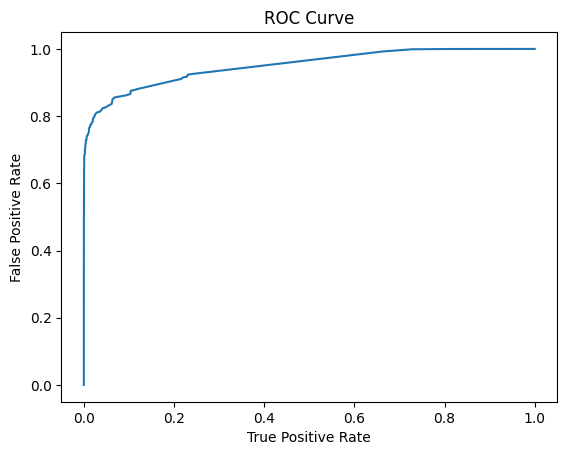

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.6706346746...|9.6591808015...|
|0.6633206382...|0.0024296685...|
|0.6575434953...|0.0031441309...|
|0.6542600371...|0.0041402015...|
|0.6520929932...|0.0051684310...|
|0.6489828418...|0.0056490134...|
|0.6472422233...|0.0061293644...|
|0.6448385730...|0.0065598272...|
|0.6427298878...|0.0069735585...|
|0.6415315740...|0.0079988715...|
+---------------+---------------+
only showing top 10 rows



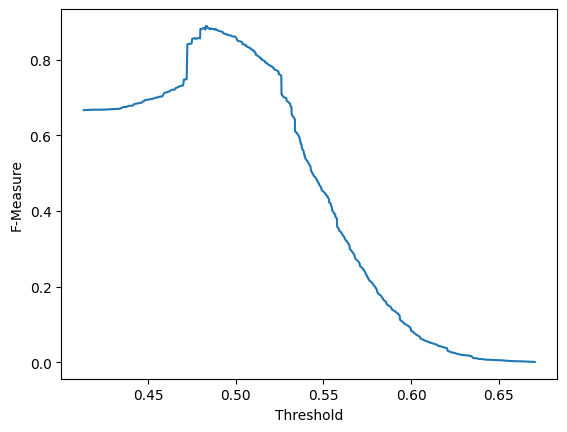

+-----------------------------------------------------+-----+----------+
|                                                  URL|label|prediction|
+-----------------------------------------------------+-----+----------+
|             https://static.cdn-apple.com.edgekey.net|    0|       0.0|
|     https://cdn.content.prod.cms.msn.com.edgekey.net|    0|       0.0|
|               https://cdn.optimizely.com.edgekey.net|    0|       0.0|
|              https://prod-edge.kohls.com.edgekey.net|    0|       0.0|
|       https://rr1---sn-2uuxa3vh-5hps.googlevideo.com|    0|       0.0|
|           https://rr1.sn-v5goxu-jhi6.googlevideo.com|    0|       0.0|
|           https://rr1---sn-8qj-8ppe7.googlevideo.com|    0|       0.0|
|https://rr1---sn-8pxuuxaj5hcvqp5-2oik.googlevideo.com|    0|       0.0|
|           https://rr1---sn-8qj-nbo6r.googlevideo.com|    0|       0.0|
|            https://rr1---sn-uvu-2tmz.googlevideo.com|    0|       0.0|
+--------------------------------------------------

In [6]:
#==============[ RANDOM FOREST ]=========================

r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0

# Build random forest model
rf = spark_ml.classification.RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)

# Train the model
rfModel = rf.fit(trainingData)

# Make predictions
predictions = rfModel.transform(testData)

df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))

#===========================ploting

#plt.clf()
lr_predictions = rfModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = sk_metrics.confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('RANDOM FOREST')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

# Get feature importances
importances = rfModel.featureImportances.toArray()

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Plot feature importances (RF doesn't have coefficients, so we use feature importances instead)
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

# Extract the summary from the returned RandomForestModel instance trained
trainingSummary = rfModel.summary

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("URL", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)
    
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified